In [1]:
# Till Wagner's python version:
#
# Reference: "How Model Complexity Influences Sea Ice Stability",
# T.J.W. Wagner & I. Eisenman, J Clim 28,10 (2015)
#
# This script numerically solves the system described by eqns (2), (8) and
# (9) in the article above (henceforth WE15).
# For computational convenience a diffusive 'ghost layer' is invoked, as
# described in WE15, Appendix A. This allows us to solve the system using
# an Implicit Euler scheme on the ghost layer (which effectively solves the
# diffusion equation) and a Forward Euler scheme for the evolution of the
# surface enthalpy. For further detailed documentation to go with this
# script, see WE15_NumericIntegration.pdf.
#
# The present script uses the default parameter values of WE15 (Table 1 and
# Section 2d) with no climate forcing (F=0) and the final part of the code
# produces the plot corresponding essentially to Figure 2 in WE15.
#
# The default configuration here runs a simulation for 30 years at 1000
# timesteps/year and a spatial resolution of 100 gridboxes, equally spaced
# between equator and pole.
#
# The computational time of this code is comparable to that of the
# corresponding Matlab code (without having performed proper performance checks)
#
# Till Wagner (tjwagner@ucsd.edu) & Ian Eisenman (eisenman@ucsd.edu), 
# created Oct 2015, minor bug fix Jan 2022 (in eq.A1, S[:,i] -> S[:,i+1]).
#
#--------------------------------------------------------------------------
import numpy as np
D = 0.6 # diffusivity for heat transport (W m^-2 K^-1)
S1 = 338; # insolation seasonal dependence (W m^-2)
A = 193 # OLR when T = 0 (W m^-2)
B = 2.1 # OLR temperature dependence (W m^-2 K^-1)
cw = 9.8 # ocean mixed layer heat capacity (W yr m^-2 K^-1)
S0 = 420 # insolation at equator (W m^-2)
S2 = 240 # insolation spatial dependence (W m^-2)
a0 = 0.7 # ice-free co-albedo at equator
a2 = 0.1 # ice=free co-albedo spatial dependence
ai = 0.4 # co-albedo where there is sea ice
Fb = 4; # heat flux from ocean below (W m^-2)
k = 2; # sea ice thermal conductivity (W m^-2 K^-1)
Lf = 9.5; # sea ice latent heat of fusion (W yr m^-3)
cg = 0.01*cw; # ghost layer heat capacity(W yr m^-2 K^-1)
tau = 1e-5; # ghost layer coupling timescale (yr)
##The default run in WE15, Fig 2 uses the time-stepping parameters: -------
#n=400; % # of evenly spaced latitudinal gridboxes (equator to pole)
#nt=1000; % # of timesteps per year (approx lower limit of stability)
#dur=200; % # of years for the whole run
##For a quicker computation, use the parameters: --------------------------
n = 100;
nt = 1000;
dur= 30;
dt = 1/nt;
#Spatial Grid -------------------------------------------------------------
dx = 1.0/n #grid box width
x = np.arange(dx/2,1+dx/2,dx) #native grid
xb = np.arange(dx,1,dx)
##Diffusion Operator (WE15, Appendix A) -----------------------------------
lam = D/dx**2*(1-xb**2)
L1=np.append(0, -lam); L2=np.append(-lam, 0); L3=-L1-L2
diffop = - np.diag(L3) - np.diag(L2[:n-1],1) - np.diag(L1[1:n],-1);
##Definitions for implicit scheme on Tg
cg_tau = cg/tau;
dt_tau = dt/tau;
dc = dt_tau*cg_tau;
kappa = (1+dt_tau)*np.identity(n)-dt*diffop/cg;
##Seasonal forcing (WE15 eq.3)
ty = np.arange(dt/2,1+dt/2,dt)
S = (np.tile(S0-S2*x**2,[nt,1])-np.tile(S1*np.cos(2*np.pi*ty),[n,1]).T*np.tile(x,[nt,1]));
S = np.vstack((S,S[0,:]));
##Further definitions
M = B+cg_tau;
aw = a0-a2*x**2 # open water albedo
kLf = k*Lf;
#Set up output arrays, saving 100 timesteps/year
E100 = np.zeros([n,dur*100]); T100 = np.zeros([n,dur*100])
p = -1; m = -1
#Initial conditions ------------------------------------------------------
T = 7.5+20*(1-2*x**2);
Tg = T; E = cw*T;
#Integration (see WE15_NumericIntegration.pdf)----------------------------
#Loop over Years ---------------------------------------------------------
for years in range(0,dur):
    #Loop within One Year-------------------------------------------------
    for i in range(0,int(nt)):
        m = m+1
        #store 100 timesteps per year
        if (p+1)*10 == m:
            p = p+1
            E100[:,p] = E
            T100[:,p] = T
        #forcing
        alpha = aw*(E>0) + ai*(E<0) #WE15, eq.4
        C = alpha*S[i,:]+cg_tau*Tg-A
        #surface temperature
        T0 = C/(M-kLf/E) #WE15, eq.A3
        T = E/cw*(E>=0)+T0*(E<0)*(T0<0); #WE15, eq.9
        #Forward Euler on E
        E = E+dt*(C-M*T+Fb); #WE15, eq.A2
        #Implicit Euler on Tg
        Tg = np.linalg.solve(kappa-np.diag(dc/(M-kLf/E)*(T0<0)*(E<0)),
        Tg+(dt_tau*(E/cw*(E>=0)+(ai*S[i+1,:]-A)/(M-kLf/E)*(T0<0)*(E<0)))) #WE15, eq.A1
#-------------------------------------------------------------------------
#output only converged, final year
tfin = np.linspace(0,1,100)
Efin = E100[:,-101:-1]
Tfin = T100[:,-101:-1]
# ------------------------------------------------------------------------
#WE15, Figure 2: Default Steady State Climatology ------------------------
# ------------------------------------------------------------------------
winter = 26 #time of coldest <T>
summer = 76 #time of warmest <T>
#compute seasonal ice edge
xi = np.zeros(100)
#if isempty(find(E<0,1))==0:
for j in range(0,len(tfin)):
    E = Efin[:,j]
    if any(E<0):
        ice = np.where(E<0)[0]
        xi[j] = x[ice[0]];
    else:
        xi[j] = max(x);
 

Error in callback <function _draw_all_if_interactive at 0x0000016F18E2C790> (for post_execute):


ValueError: 
^\\circ
 ^
Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline}, found '\'  (at char 1), (line:1, col:2)

ValueError: 
^\\circ
 ^
Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline}, found '\'  (at char 1), (line:1, col:2)

<Figure size 640x480 with 10 Axes>

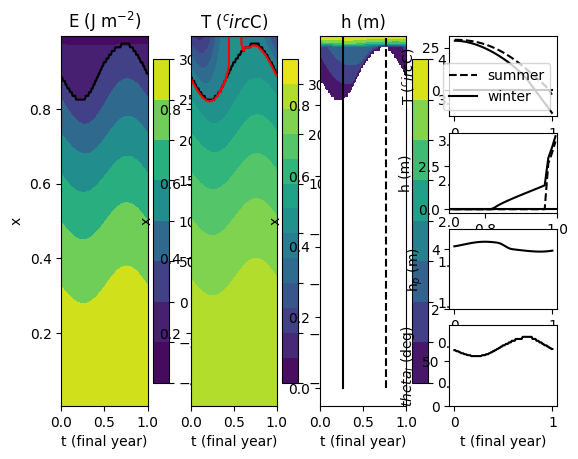

In [2]:

import matplotlib.pyplot as plt
plt.figure(2)
#plot enthalpy (Fig 2a)
plt.subplot(141)
clevsE = np.append(np.arange(-40,20,20),np.arange(50,350,50))
plt.contourf(tfin,x,Efin,clevsE)
plt.colorbar()
#plot ice edge on E
plt.plot(tfin,xi,'k')
plt.xlabel('t (final year)')
plt.ylabel('x')
plt.title(r'E (J m$^{-2}$)')
 
#plot temperature (Fig 2b)
plt.subplot(142)
clevsT = np.arange(-30.001,35.,5.)
plt.contourf(tfin,x,Tfin,clevsT)
plt.colorbar()
#plot ice edge on T
plt.plot(tfin,xi,'k')
#plot T=0 contour (the region between ice edge and T=0 contour is the
# region of summer ice surface melt)
plt.contour(tfin,x,Tfin,[-0.001],colors='r',linestyles='-')
plt.xlabel('t (final year)')
plt.ylabel('x')
plt.title(r'T ($^circ$C)')
 
#plot the ice thickness (Fig 2c)
plt.subplot(1,4,3)
clevsh = np.arange(0.00001,4.5,.5)
hfin = -Efin/Lf*(Efin<0)
plt.contourf(tfin,x,hfin,clevsh)
plt.colorbar()
#plot ice edge on h
# plt.contour(tfin,x,hfin,[0],colors='k')
plt.plot([tfin[winter], tfin[winter]],[0,max(x)],'k')
plt.plot([tfin[summer], tfin[summer]],[0,max(x)],'k--')
plt.xlabel('t (final year)')
plt.ylabel('x')
plt.title('h (m)')
 
#plot temperature profiles (Fig 2d)
plt.subplot(444)
Summer, = plt.plot(x,Tfin[:,summer],'k--',label='summer')
Winter, = plt.plot(x,Tfin[:,winter],'k',label='winter')
plt.plot([0,1],[0,0],'k')
plt.xlabel('x')
plt.ylabel(r'T ($^circ$C)')
plt.legend(handles = [Summer,Winter],loc=0)
 
#plot ice thickness profiles (Fig 2e)
plt.subplot(448)
plt.plot(x,hfin[:,summer],'k--')
plt.plot(x,hfin[:,winter],'k')
plt.plot([0,1], [0,0],'k')
plt.xlim([0.7,1])
plt.xlabel('x')
plt.ylabel('h (m)')
 
#plot seasonal thickness cycle at pole (Fig 2f)
plt.subplot(4,4,12)
plt.plot(tfin,hfin[-1,:],'k')
plt.xlabel('t (final year)')
plt.ylabel(r'h$_p$ (m)')
plt.ylim([2, 1.1*max(hfin[-1,:])])
 
#plot ice edge seasonal cycle (Fig 2g)
plt.subplot(4,4,16)
xideg = np.degrees(np.arcsin(xi));
plt.plot(tfin,xideg,'k-')
plt.ylim([0,90])
plt.xlabel('t (final year)')
plt.ylabel(r'$theta_i$ (deg)');
